<a href="https://colab.research.google.com/github/arijul2/Parkinson-s_Detection_ML/blob/main/ParkinsonsDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Parkinson's Spiral Drawing and CNN to Detect Parkinson's Disease

In [1]:
import numpy as np

In [2]:
import cv2

In [3]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd

In [6]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
!unzip -qo Parkinson_disease_detection.zip

--2024-08-12 09:17:51--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.36, 52.219.158.215, 52.219.158.119, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8201907 (7.8M) [application/x-zip-compressed]
Saving to: ‘Parkinson_disease_detection.zip’

Parkinson_disease_d 100%[===================>]   7.82M  3.61MB/s    in 2.2s    

2024-08-12 09:17:54 (3.61 MB/s) - ‘Parkinson_disease_detection.zip’ saved [8201907/8201907]



Loading the Data

In [7]:
data_train = np.load('Parkinson_disease_detection/train_set.npz', allow_pickle=True)
x_train = data_train['arr_0']
y_train = data_train['arr_1']

print(x_train.shape)
print(y_train.shape)

(72, 256, 256, 3)
(72,)


In [8]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
!unzip -qo Parkinson_disease_detection.zip

--2024-08-12 09:17:55--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.36, 52.219.158.215, 52.219.158.119, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8201907 (7.8M) [application/x-zip-compressed]
Saving to: ‘Parkinson_disease_detection.zip.1’

Parkinson_disease_d 100%[===================>]   7.82M  4.00MB/s    in 2.0s    

2024-08-12 09:17:58 (4.00 MB/s) - ‘Parkinson_disease_detection.zip.1’ saved [8201907/8201907]



In [9]:
data_test = np.load('Parkinson_disease_detection/test_set.npz', allow_pickle=True)
x_test = data_test['arr_0']
y_test = data_test['arr_1']

print(x_test.shape)
print(y_test.shape)

(30, 256, 256, 3)
(30,)


Data Distribution

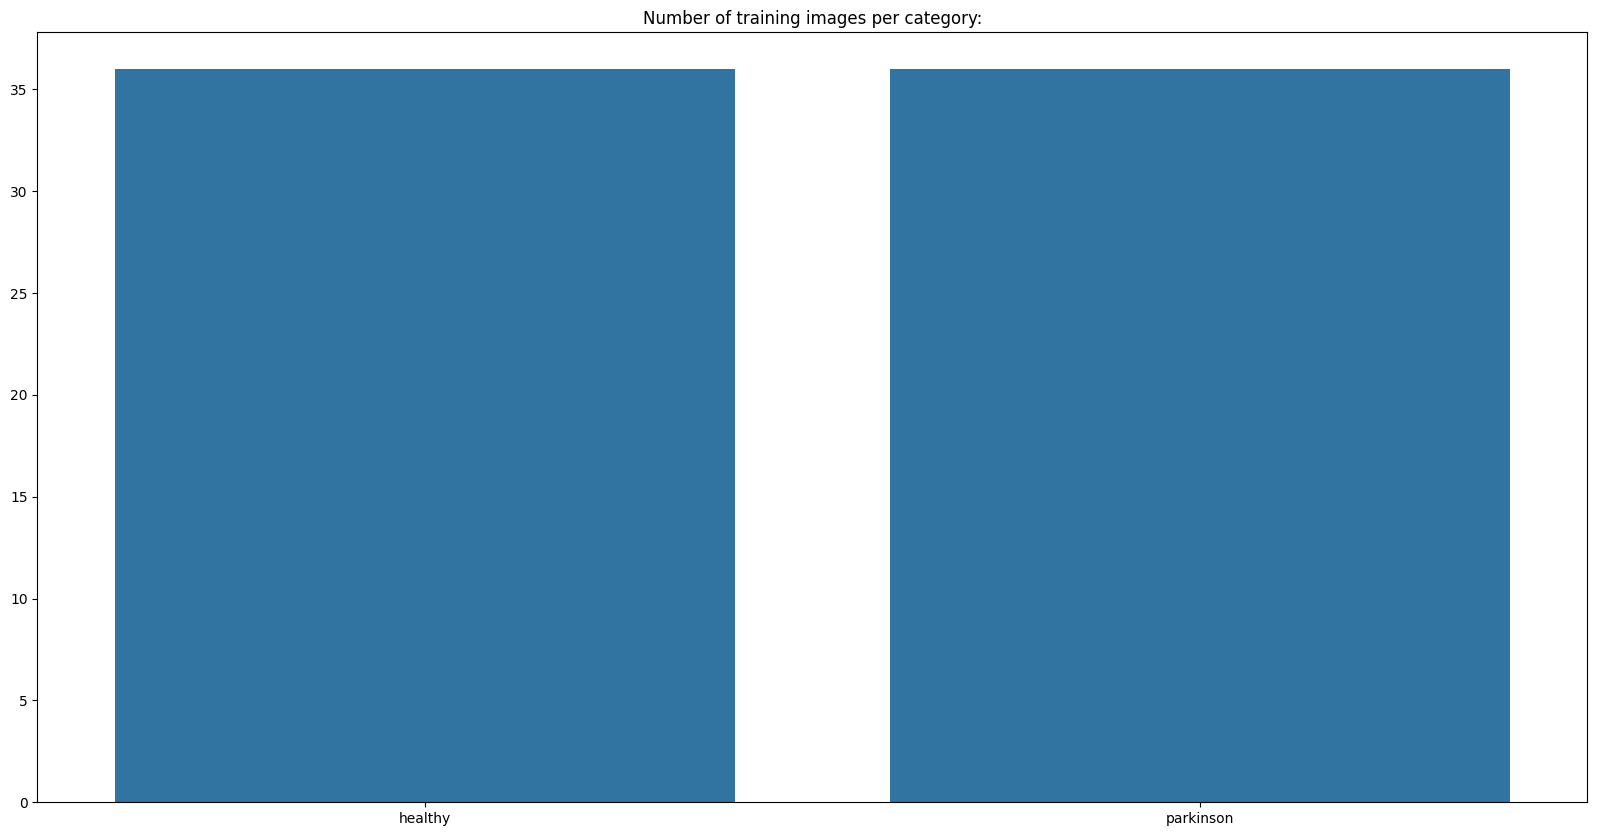

In [10]:
unique_train, count = np.unique(y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_train, y=count).set_title("Number of training images per category:")
plt.show()

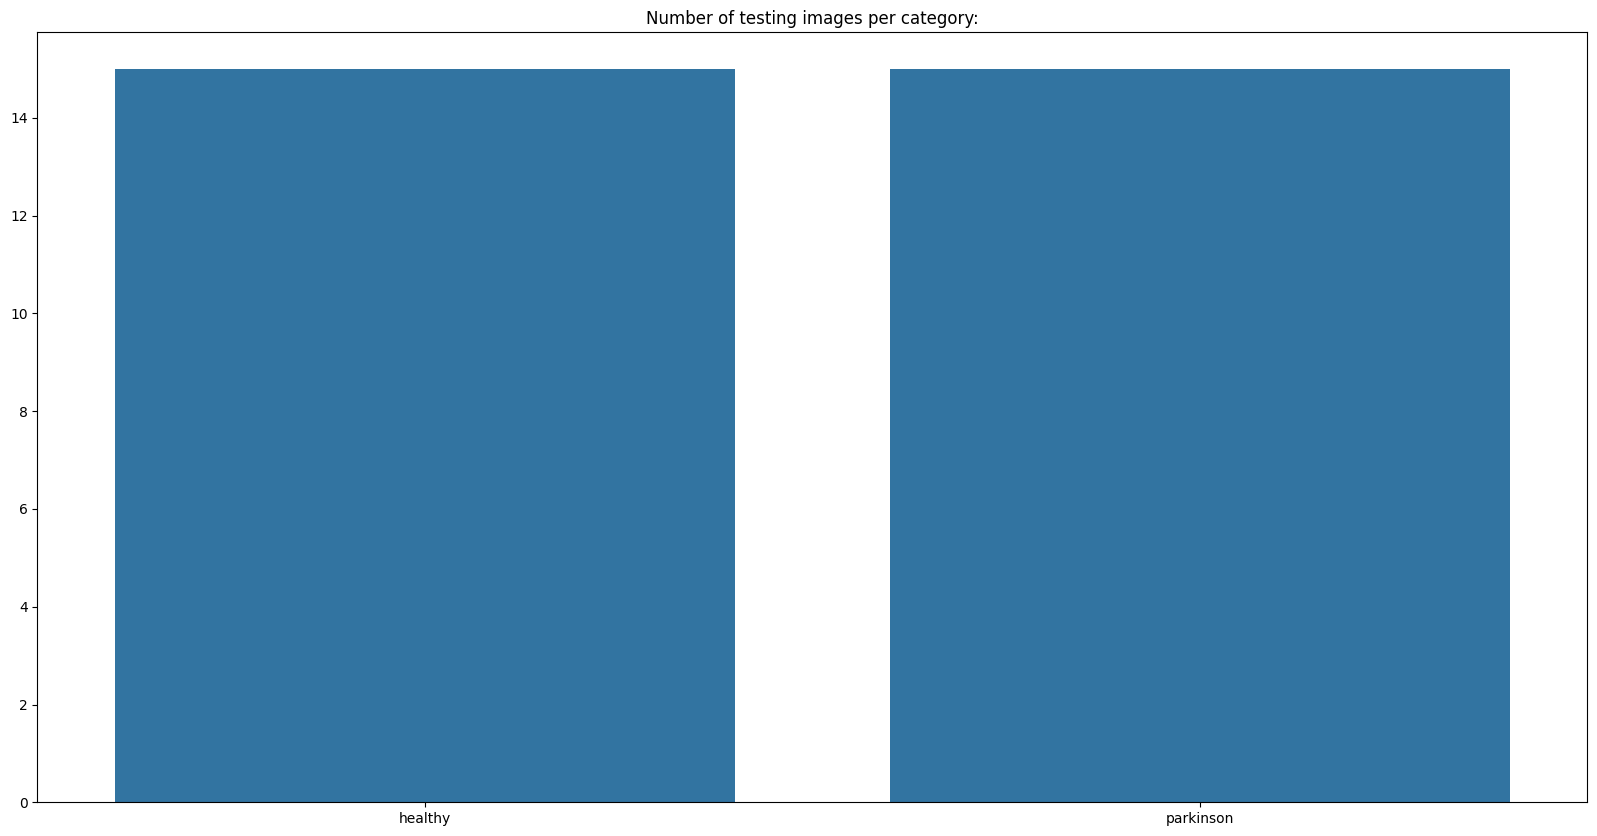

In [11]:
unique_test, count_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_test, y=count_test).set_title("Number of testing images per category:")

plt.show()

Augmenting the Dataset

In [12]:
train_data_generator = ImageDataGenerator(rotation_range=360,
                                    width_shift_range=0.0,
                                    height_shift_range=0.0,
#                                    brightness_range=[0.5, 1.5],
                                    horizontal_flip=True,
                                    vertical_flip=True)

# when called it will generate new training images by augmenting current images
# i.e. randonmly rotates the image (useful as directional characteristics don't matter)

In [13]:
x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

In [14]:
for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)

#iteratively augments each original training image using generator
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

5040
5040
5112
5112


In [15]:
test_data_generator = ImageDataGenerator(rotation_range=360,
                                    width_shift_range=0.0,
                                    height_shift_range=0.0,
#                                     brightness_range=[0.5, 1.5],
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

In [16]:
for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

600
600
630
630


## Visualizing the Images in Train and Test Set

Train Set Example

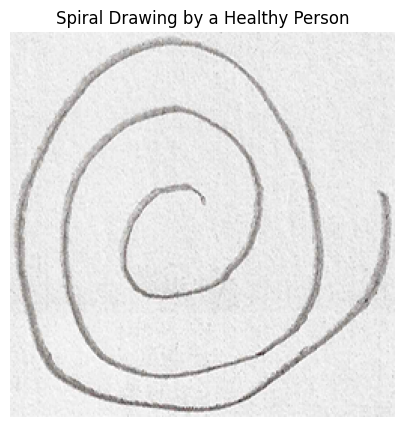

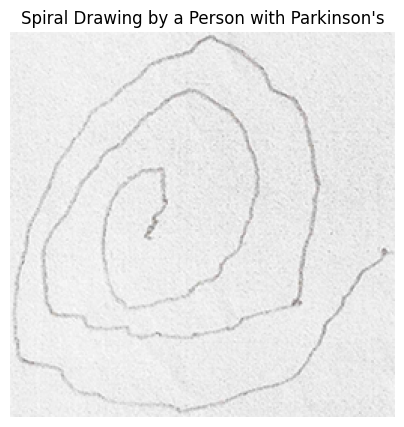

In [17]:
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_train) if v=='healthy']
img_healthy = x_train[idx_healthy[5]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_train) if v=='parkinson']
img_parkinson = x_train[idx_parkinson[5]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person with Parkinson's")
plt.axis('off')
plt.show()

Test Set Example

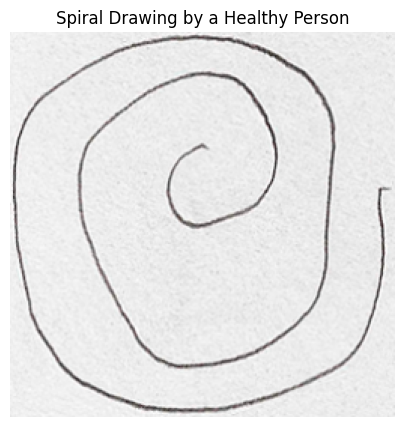

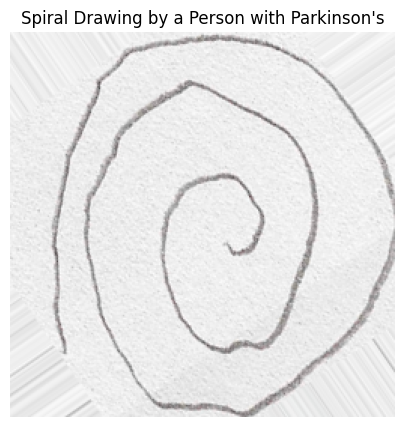

In [18]:
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_test) if v=='healthy']
img_healthy = x_train[idx_healthy[20]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_test) if v=='parkinson']
img_parkinson = x_train[idx_parkinson[20]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person with Parkinson's")
plt.axis('off')
plt.show()